In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
import matplotlib.pyplot as plt

# Set default figure size
plt.rcParams['figure.figsize'] = (6, 4)  # width, height in inches

# Set default font sizes
plt.rcParams['font.size'] = 15  # Default font size
plt.rcParams['axes.titlesize'] = 15  # Title font size
plt.rcParams['axes.labelsize'] = 15  # Label font size
plt.rcParams['xtick.labelsize'] = 15  # x-axis tick label font size
plt.rcParams['ytick.labelsize'] = 15  # y-axis tick label font size
plt.rcParams['legend.fontsize'] = 15  # Legend font size
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [244]:
import matplotlib
matplotlib.rcParams['svg.fonttype'] = 'none'

In [4]:

figdir = '/mnt/home/szheng/ceph/place_variability/fig/paper/figure_loc_amp_drift'
misc.get_or_create_subdir(figdir)
data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'
misc.get_or_create_subdir(data_dir)


'/mnt/home/szheng/ceph/place_variability/data/paper'

In [249]:
import database
db = database.db

subdb = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
subdb = subdb.query('ntrials>=20&n_neurons>=50')
to_exclude_sess = ['e16_3m2_211211']
subdb=subdb.loc[~subdb['sess_name'].isin(to_exclude_sess)]


import pf_recombine_central as pfrc
import fr_map_one_session as fmos
import switch_detection_one_session as sdos
import get_all_switch_add_metrics as gasam

import preprocess_one_session as prepos

In [6]:
fn = 'prepped_data_agg.p'
fn_full = os.path.join(data_dir,fn)
prepped_data_agg = pickle.load(open(fn_full,'rb'))

all_fields_recombined_all = prepped_data_agg['all_fields_recombined_all']
pf_params_recombined_all=  prepped_data_agg['pf_params_recombined_all']
fr_map_trial_df_all= prepped_data_agg['fr_map_trial_df_all']
occu_map_all = prepped_data_agg['occu_map_all']
fr_map_all = prepped_data_agg['fr_map_all']

pval_all = prepped_data_agg['pval_all']
X_pwc_all = prepped_data_agg['X_pwc_all']
X_raw_all = prepped_data_agg['X_raw_all']
changes_df_all = prepped_data_agg['changes_df_all']
var_res_all_test = prepped_data_agg['var_res_all']
# corr_all = prepped_data_agg['corr_all']
all_sw_d_all = prepped_data_agg['all_sw_d_all']
all_sw_with_metrics_d_all = prepped_data_agg['all_sw_with_metrics_d_all']
best_n_all_test = prepped_data_agg['best_n_all']
spk_beh_df_all = prepped_data_agg['spk_beh_df_all']

pf_params_all = prepped_data_agg['pf_params_all']
all_fields_all = prepped_data_agg['all_fields_all']

ntrials_per_tt=fr_map_trial_df_all.groupby(level=(0,1,2,3)).apply(lambda x:x.dropna(axis=1,how='all').shape[1])
ntrials_mask = ntrials_per_tt.groupby(level=(0,1,2)).apply(lambda x:(x>=7).all()) 



/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [439]:
# prepped_data_agg['pf_params_all']=pf_params_all
# prepped_data_agg['all_fields_all']=all_fields_all
# pickle.dump(prepped_data_agg,open(fn_full,'wb'))

In [434]:
# all_fields_all = {}
# pf_params_all = {}
# for k,row in subdb.iterrows():
#     ddf=row['data_dir_full']
#     sess=row['sess_name']
#     ani = row['animal_name.1']
#     pf_res = pf.field_detection_avg_wrapper(ddf, dosave=False,force_reload=False, load_only=True,
#                                             save_fn='place_field_afterheadscan.p',
#                                             shuffle_fn='frmap_null_afterheadscan.p',
#                                            )
#     all_fields = pd.concat(pf_res['all_fields'],axis=0)
#     pf_params = pd.concat(pf_res['params'],axis=0)
#     pf_params_all[ani,sess] = pf_params
#     all_fields_all[ani,sess] = all_fields
# pf_params_all = pd.concat(pf_params_all,axis=0)
# all_fields_all = pd.concat(all_fields_all,axis=0)

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/place_field_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/place_field_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/place_field_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220119/py_data/place_field_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220120/py_data/place_field_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211019/py_data/place_field_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210328/py_data/place_field_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211116/py_data/place_field_afterheadscan.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e16/

In [7]:
savefn_full = os.path.join(data_dir,'per_field_metrics_shtest_with_1cp.p')
# pickle.dump(per_field_metrics_all,open(savefn_full,'wb'))
per_field_metrics_all=pickle.load(open(savefn_full,'rb'))

In [11]:
def get_val_per_lag(mat):
    '''
    col: lag
    index: count
    '''
    mat = mat.dropna(axis=1,how='all').dropna(axis=0,how='all')
    mat = mat.values
    ntrials = mat.shape[0]
    vals_per_lag_l = {}
    for lag in range(1,ntrials-1):
        vals_per_lag = np.diag(mat,lag)
        vals_per_lag_l[lag] = pd.Series(vals_per_lag)
    return pd.DataFrame(vals_per_lag_l)


    

# early to late per neuron ratemap trial to trial correlation change

### first second half +even-odd ratemap corr, per neuron


In [8]:
def first_second_half_corr(val):
    val = val.dropna(axis=1)
    ncols = val.shape[1]
    half_ncol =int(ncols//2)
    half_1=val.iloc[:,:half_ncol].mean(axis=1)
    half_2=val.iloc[:,half_ncol:].mean(axis=1)
    r,_=scipy.stats.pearsonr(half_1,half_2)
    return r

def even_odd_corr(val):
    val = val.dropna(axis=1)
    ncols = val.shape[1]
    half_ncol =int(ncols//2)
    half_1=val.iloc[:,:ncols:2].mean(axis=1)
    half_2=val.iloc[:,1:(ncols+1):2].mean(axis=1)
    r,_=scipy.stats.pearsonr(half_1,half_2)
    return r

In [28]:
%%time
gpb_unit = fr_map_trial_df_all.groupby(level=(0,1,2,3,4))
first_second_corr_all = gpb_unit.apply(first_second_half_corr)
even_odd_corr_all = gpb_unit.apply(even_odd_corr)
corr_all=pd.concat({'even_odd':even_odd_corr_all,'first_second':first_second_corr_all},axis=1).dropna(axis=0)

CPU times: user 23.2 s, sys: 20 ms, total: 23.2 s
Wall time: 23.2 s


Text(0.5, 1.0, 'ratemap corr per neuron')

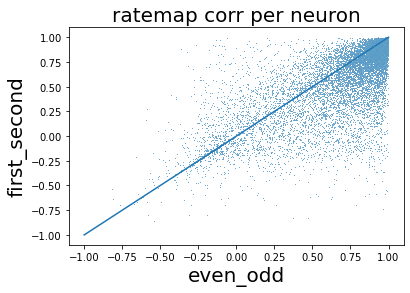

In [123]:
# even odd sig higher than first second
scipy.stats.wilcoxon(corr_all['even_odd']-corr_all['first_second'],alternative='greater')
fig,ax=plt.subplots()
sns.scatterplot(data=corr_all,x='even_odd',y='first_second',ax=ax,s=1.)
ax.plot([-1,1],[-1,1])
ax.set_title('ratemap corr per neuron')

In [137]:
# look at nice place cells
per_neuron_metrics_all = per_field_metrics_all.groupby(level=(0,1,2,3,4)).mean()
ma = per_neuron_metrics_all['si'] > 0.5
ind_ma = ma.loc[ma].index

In [138]:
ind = corr_all.index.intersection(ind_ma)
corr_all_sub = corr_all.loc[ind]

In [151]:
diff_per_sess=corr_all_sub.diff(axis=1).iloc[:,1].groupby(level=(0,1,2)).mean()
gpb=diff_per_sess.groupby(level=2)
gpb.apply(lambda x:scipy.stats.wilcoxon(x,alternative='less'))

0    (0.0, 1.4210854715202004e-14)
1                (0.0, 0.00390625)
Name: first_second, dtype: object

WilcoxonResult(statistic=8140206.0, pvalue=7.903611165712311e-266)
WilcoxonResult(statistic=292822.0, pvalue=4.865505049407463e-74)


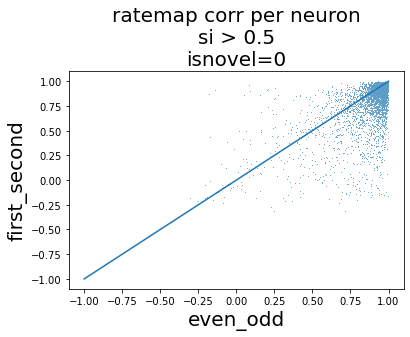

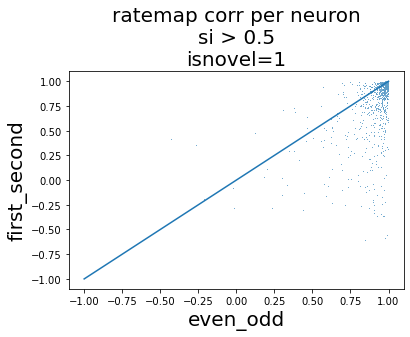

In [154]:
# even odd sig higher than first second
for isnovel in [0,1]:
    corr_toplot = corr_all_sub.loc[(slice(None),slice(None),isnovel)]
    test=scipy.stats.wilcoxon(corr_toplot['even_odd']-corr_toplot['first_second'],alternative='greater')
    print(test)
    fig,ax=plt.subplots()
    sns.scatterplot(data=corr_toplot,x='even_odd',y='first_second',ax=ax,s=1.)
    ax.plot([-1,1],[-1,1])
    ax.set_title(f'ratemap corr per neuron\nsi > 0.5\nisnovel={isnovel}')

<Axes: >

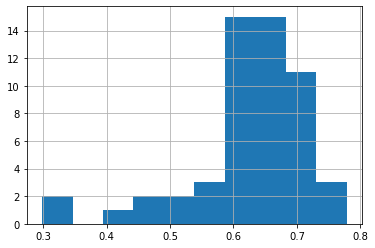

In [33]:
first_second_corr_all.groupby(level=(0,1,2)).mean().hist()

### PV, first second half corr + even odd

In [377]:
# look at nice place cells
per_neuron_metrics_all = per_field_metrics_all.groupby(level=(0,1,2,4)).max()
ma = per_neuron_metrics_all['si'] > 0.5
ind_ma = ma.loc[ma].index

# look at switching fields
ma = per_neuron_metrics_all['fit_var_ratio'] > 0.1
ind_ma = ma.loc[ma].index

fr_map_trial_df_all_highsi=fr_map_trial_df_all.unstack(level=(-1,-3)).loc[ind_ma].stack(level=(-2,-1)).reorder_levels((0,1,2,5,3,4))

In [378]:
gpb_sess=fr_map_trial_df_all.groupby(level=(0,1,2,3))
# gpb_sess = fr_map_trial_df_all_highsi.groupby(level=(0,1,2,3))

In [379]:
first_second_corr_pv = gpb_sess.apply(first_second_half_corr) 
even_odd_corr_pv = gpb_sess.apply(even_odd_corr)
corr_pv=pd.concat({'even_odd':even_odd_corr_pv,'first_second':first_second_corr_pv},axis=1).dropna(axis=0)

In [380]:
first_second_corr_pv

e13_16f1  e13_16f1_210302  0  0.0    0.871620
                              1.0    0.791924
          e13_16f1_210312  0  0.0    0.852922
                              1.0    0.892670
          e13_16f1_210314  0  0.0    0.899895
                                       ...   
e16_3m2   e16_3m2_211212   1  1.0    0.676251
          e16_3m2_211213   0  0.0    0.827266
                              1.0    0.864733
                           1  0.0    0.847851
                              1.0    0.828971
Length: 108, dtype: float64

[Text(0, 0.5, 'PV Corr')]

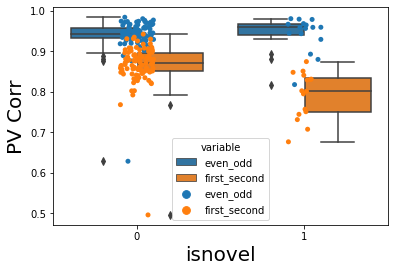

In [381]:
toplot=corr_pv.reset_index(level=2).rename({'level_2':'isnovel',},axis=1).melt(id_vars='isnovel')
fig,ax=plt.subplots()
sns.boxplot(data=toplot,x='isnovel',y='value',hue='variable',ax=ax) # per session
sns.stripplot(data=toplot,x='isnovel',y='value',hue='variable',ax=ax)
# ax.set(ylabel='PV Corr',title='Si > 0.5')
ax.set(ylabel='PV Corr')


<Axes: >

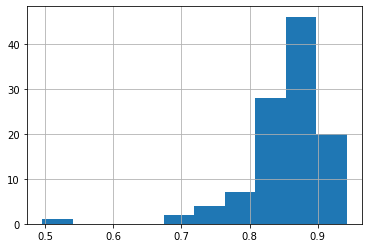

In [40]:
first_second_corr_pv.hist()

### PV all trial


In [383]:
# gpb_sess=fr_map_trial_df_all.groupby(level=(0,1,2,3))
gpb_sess=fr_map_trial_df_all_highsi.groupby(level=(0,1,2,3))
pv_corr_alltrials = gpb_sess.corr()


In [385]:
gpb_corr_sess=pv_corr_alltrials.groupby(level=(0,1,2,3))

pv_corr_per_lag=gpb_corr_sess.apply(get_val_per_lag)

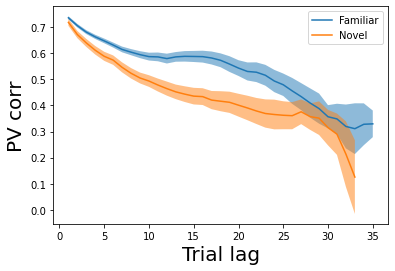

In [386]:
gpb_task=pv_corr_per_lag.groupby(level=(2))
fig,ax=plt.subplots()
isfam_d_str = {0:'Familiar',1:'Novel'}
for k,val in gpb_task:
    fig,ax=ph.mean_error_plot(val,fig=fig,ax=ax,label=isfam_d_str[k])
    ax.set(xlabel='Trial lag',ylabel='PV corr')
ax.legend()

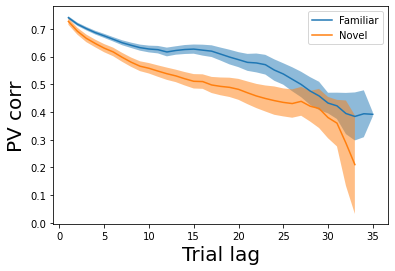

In [92]:
gpb_task=pv_corr_per_lag.groupby(level=(2))
fig,ax=plt.subplots()
isfam_d_str = {0:'Familiar',1:'Novel'}
for k,val in gpb_task:
    fig,ax=ph.mean_error_plot(val,fig=fig,ax=ax,label=isfam_d_str[k])
    ax.set(xlabel='Trial lag',ylabel='PV corr')
ax.legend()

# pv seperate into place and nonplace cell

In [233]:
exclude_sess_ma = fr_map_trial_df_all.index.get_level_values(1)!='e13_26m1_210913'

In [235]:
exclude_sess_ma

array([False, False, False, ...,  True,  True,  True])

In [257]:
# look at nice place cells
per_neuron_metrics_all = per_field_metrics_all.groupby(level=(0,1,2,4)).max()
ma = per_neuron_metrics_all['si'] > 0.5

# fr_map_trial_df_all_ = fr_map_trial_df_all.loc[exclude_sess_ma].unstack(level=(-1,-3))
fr_map_trial_df_all_ = fr_map_trial_df_all.unstack(level=(-1,-3))
hi_si_ind = ma.loc[ma].index.intersection(fr_map_trial_df_all_.index)
low_si_ind=ma.loc[~ma].index.intersection(fr_map_trial_df_all_.index)

fr_map_trial_df_all_highsi=fr_map_trial_df_all_.loc[hi_si_ind].stack(level=(-2,-1)).reorder_levels((0,1,2,5,3,4))
fr_map_trial_df_all_lowsi=fr_map_trial_df_all_.loc[low_si_ind].stack(level=(-2,-1)).reorder_levels((0,1,2,5,3,4))

reorder = lambda df:df.groupby(level=(0,1,2)).apply(lambda x:x.sort_index(level=(3,4,5)).droplevel(level=(0,1,2)))
fr_map_trial_df_all_highsi = reorder(fr_map_trial_df_all_highsi)
fr_map_trial_df_all_lowsi = reorder(fr_map_trial_df_all_lowsi)

In [30]:
# pc_inds=all_fields_all.reset_index('field_index').index.unique()


# all_inds = fr_map_trial_df_all.unstack(level=(-1)).index

# non_pc_inds = all_inds.difference(pc_inds).unique()

# fr_map_trial_df_all_highsi = fr_map_trial_df_all.unstack(level=(-1)).loc[pc_inds].stack(-1)

# fr_map_trial_df_all_lowsi = fr_map_trial_df_all.unstack(level=(-1)).loc[non_pc_inds].stack(-1)

In [16]:
reload(ph)

<module 'plot_helper' from '/mnt/home/szheng/projects/util_code/plot_helper.py'>

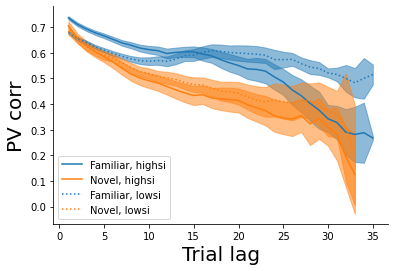

In [260]:
df_d = {'highsi':fr_map_trial_df_all_highsi,'lowsi':fr_map_trial_df_all_lowsi}
pv_corr_per_lag_d={}
fig,ax=plt.subplots()
color_l = ['C0','C1']
linestyle_l={'highsi':'-','lowsi':':'}
for ksi,df in df_d.items():
    gpb_sess=df.groupby(level=(0,1,2,3))
    pv_corr_alltrials = gpb_sess.corr()
    gpb_corr_sess=pv_corr_alltrials.groupby(level=(0,1,2,3))
    pv_corr_per_lag=gpb_corr_sess.apply(get_val_per_lag)
    pv_corr_per_lag_d[ksi]=pv_corr_per_lag
    gpb_task = pv_corr_per_lag.groupby(level=(2))
#     fig,ax=plt.subplots()
    isfam_d_str = {0:'Familiar',1:'Novel'}
    
    for k,val in gpb_task:
        c = color_l[k]
        linestyle = linestyle_l[ksi]
        
        fig,ax=ph.mean_error_plot(val,fig=fig,ax=ax,label=f'{isfam_d_str[k]}, {ksi}',linestyle=linestyle,c=c)
        ax.set(xlabel='Trial lag',ylabel='PV corr')
    ax.legend()
#     ax.set_title(ksi)

sns.despine()
for fmt in ['png','svg']:
    figfn = os.path.join(figdir,f'pv_corr_fam_nov_highlow_si_vs_triallag.{fmt}')
#     figfn = os.path.join(figdir,f'pv_corr_fam_nov_highlow_si_vs_triallag_exclude_longestsess.{fmt}')
    fig.savefig(figfn,bbox_inches='tight')

In [130]:
for q in [0,0.2,0.4,0.6,0.8,1]:
    print(per_neuron_metrics_all_tt['tot_var_norm'].quantile(q))

0.019379490726192976
1.0061541656979818
1.561433343326746
2.307704271863884
3.6727715294262464
123.83407000007219


In [229]:
# ma_ind=per_neuron_metrics_all.query('si>0.5&fit_var_ratio>0.4').index
# ma_ind=per_neuron_metrics_all.query('fit_var_ratio>0.3').index

per_neuron_metrics_all_tt=per_field_metrics_all.groupby(level=(0,1,2,3,4),sort=False).mean()
# ma_ind=per_neuron_metrics_all_tt.query('fit_var_ratio>0.01').index
# ma_ind=per_neuron_metrics_all_tt.query('fit_var_ratio<0.01 & fr_cv_beh > 0.95').index

# ma_ind=per_neuron_metrics_all_tt.query('fit_var_ratio>0.01 & fr_cv_beh < 0.58').index
# ma_ind_not=per_neuron_metrics_all_tt.query('fit_var_ratio<0.01 & fr_cv_beh < 0.58').index

ma_ind=per_neuron_metrics_all_tt.query('fit_var_ratio>0.01 & fr_cv_beh > 0.58').index
ma_ind_not=per_neuron_metrics_all_tt.query('fit_var_ratio>0.01 & fr_cv_beh < 0.58').index

# ma_ind=per_neuron_metrics_all_tt.query('fit_var_ratio>0.01 & tot_var_norm > 3.6 & tot_var_norm < 10').index
# ma_ind_not=per_neuron_metrics_all_tt.query('fit_var_ratio<0.01 & tot_var_norm > 3.6 & tot_var_norm < 10').index

ma_ind=per_neuron_metrics_all_tt.query('mean>5.9&si>0.5').index
ma_ind_not=per_neuron_metrics_all_tt.query('mean>5.9&si<0.5').index


# get rid of "both", replace with a copy with 0 and 1
def replace_both_in_ma_ind(ma_ind):
    ma_ind_new=[]
    for ind in ma_ind:
        if ind[3]=='both':
            ma_ind_new.append((*ind[:3],0,*ind[4:]))
            ma_ind_new.append((*ind[:3],1,*ind[4:]))
        else:
            ma_ind_new.append(ind)
    ma_ind_new = pd.MultiIndex.from_tuples(ma_ind_new)
    return ma_ind_new

ma_ind_new = replace_both_in_ma_ind(ma_ind)
ma_ind_new_not = replace_both_in_ma_ind(ma_ind_not)

In [230]:
fr_map_trial_df_all_reset = fr_map_trial_df_all.reset_index(level=5)
# ma_ind_new_not=fr_map_trial_df_all_reset.index.difference(ma_ind_new)
fr_map_trial_df_all_sw = fr_map_trial_df_all_reset.loc[ma_ind_new].set_index('level_5',append=True)
fr_map_trial_df_all_nosw = fr_map_trial_df_all_reset.loc[ma_ind_new_not].set_index('level_5',append=True)


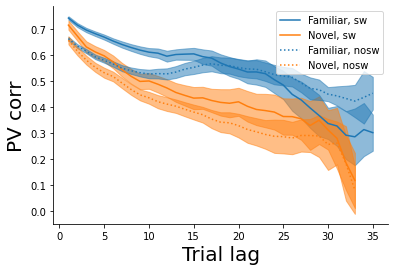

In [251]:
df_d = {'sw':fr_map_trial_df_all_sw,'nosw':fr_map_trial_df_all_nosw}
pv_corr_per_lag_d={}
fig,ax=plt.subplots()
color_l = ['C0','C1']
linestyle_l={'sw':'-','nosw':':'}
do_zscore = False#True
for ksi,df in df_d.items():
    if do_zscore:
        df=df.groupby(level=(0,1,2,3,4)).apply(lambda x:(x - np.nanmean(x,axis=(0,1)))/(1e-10+np.nanstd(x,axis=(0,1))))
    
    gpb_sess=df.groupby(level=(0,1,2,3))
    pv_corr_alltrials = gpb_sess.corr()
    gpb_corr_sess=pv_corr_alltrials.groupby(level=(0,1,2,3))
    pv_corr_per_lag=gpb_corr_sess.apply(get_val_per_lag)
    pv_corr_per_lag_d[ksi]=pv_corr_per_lag
    gpb_task = pv_corr_per_lag.groupby(level=(2))
#     fig,ax=plt.subplots()
    isfam_d_str = {0:'Familiar',1:'Novel'}
    
    for k,val in gpb_task:
        c = color_l[k]
        linestyle = linestyle_l[ksi]
        
        fig,ax=ph.mean_error_plot(val,fig=fig,ax=ax,label=f'{isfam_d_str[k]}, {ksi}',linestyle=linestyle,c=c)
        ax.set(xlabel='Trial lag',ylabel='PV corr')
    ax.legend()
#     ax.set_title(ksi)

sns.despine()
# for fmt in ['png','svg']:
#     figfn = os.path.join(figdir,f'pv_corr_fam_nov_highlow_si_vs_triallag_upperhalfFR.{fmt}')
#     fig.savefig(figfn,bbox_inches='tight')

In [215]:
nneuron=100
x_start = np.random.normal(size=(nneuron))
step_std=1
T=20
x_l = [x_start]
diff_direction = np.random.normal(size=(nneuron)) * 0
for i in range(T):
#     x_next = x_l[-1] + np.random.normal(size=(nneuron)) * step_std + diff_direction
    x_next = np.random.normal(size=(nneuron)) * step_std
    x_l.append(x_next)
x_l = np.stack(x_l,axis=0)
x_l.shape
 

(21, 100)

(-0.2, 1.1)

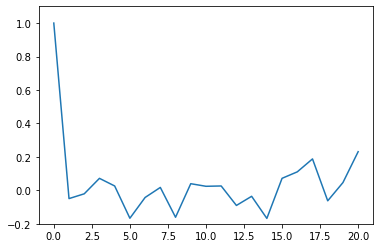

In [220]:
plt.plot(np.corrcoef(x_l)[0])
plt.ylim([-0.2,1.1])

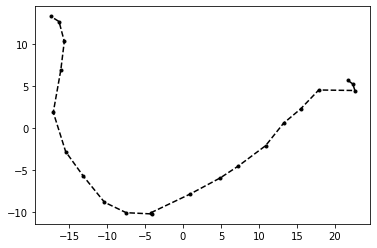

In [197]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
x_pc=pca.fit_transform(x_l)
fig,ax=plt.subplots()
ax.plot(x_pc[:,0],x_pc[:,1],'k--',marker='o',ms=3)


In [34]:
fr_map_trial_df_all.loc[ma_ind_new]

ValueError: operands could not be broadcast together with shapes (2421,4) (6,) (2421,4) 

In [24]:
best_n_all_test

e13_26m1  e13_26m1_210913  0  0.0   3   0    1
                                    27  0    0
                                    29  0    3
                                        1    0
                                        2    0
                                            ..
e14_2m3   e14_2m3_201118   0  both  30  0    0
                                    32  0    0
                                    38  0    0
                                    47  0    0
                                    53  0    0
Length: 14438, dtype: int64

In [29]:
has_sw_ma = best_n_all_test > 0
has_sw_ma_cell=has_sw_ma.groupby(level=(0,1,2,3,4),sort=False).any()

In [30]:
has_sw_ma_cell

e13_26m1  e13_26m1_210913  0  0.0   3      True
                                    27    False
                                    29     True
                                    30    False
                                    31     True
                                          ...  
e14_2m3   e14_2m3_201118   0  both  30    False
                                    32    False
                                    38    False
                                    47    False
                                    53    False
Length: 10164, dtype: bool

In [23]:
fr_map_trial_df_all_highsi

0         1         2   \
e13_16f1 e13_16f1_210302 0 0.0 12.0  0   0.000000  0.707702  0.978546   
                                     1   0.000000  1.086691  1.408718   
                                     2   0.000000  1.830679  2.162798   
                                     3   0.000000  2.883719  3.024042   
                                     4   0.000000  4.111754  3.742877   
...                                           ...       ...       ...   
e16_3m2  e16_3m2_211213  1 1.0 207.0 71  1.501721  0.000000  1.641610   
                                     72  1.160569  0.000000  1.377616   
                                     73  0.781422  0.000000  1.113937   
                                     74  0.472885  0.000000  0.883765   
                                     75  0.304498  0.000000  0.741196   

                                               3         4         5   \
e13_16f1 e13_16f1_210302 0 0.0 12.0  0   0.700436  0.272510  0.068929   
                                     1   1.018228  0.416853  0.115111   
                                     2   1.659129  0.691757  0.217383   
                                     3   2.667279  1.076733  0.387948   
                                     4   4.140979  1.561435  0.638248   
...                                           ...       ...       ...   
e16_3m2  e16_3m2_211213  1 1.0 207.0 71  0.033349  2.608139  1.111305   
                                     72  0.008593  1.762497  0.796221   
                                     73  0.001769  0.993064  0.488047   
                                     74  0.000304  0.462326  0.258484   
                                     75  0.000000  0.213307  0.142098   

                                               6          7         8   \
e13_16f1 e13_16f1_210302 0 0.0 12.0  0   1.123610   8.176753  0.971016   
                                     1   1.096873   9.432746  1.330805   
                                     2   1.062131  11.863770  2.121210   
                                     3   1.070640  14.898099  3.398358   
                                     4   1.221076  17.436317  5.013933   
...                                           ...        ...       ...   
e16_3m2  e16_3m2_211213  1 1.0 207.0 71  3.194294   1.430057  1.217686   
                                     72  2.340608   0.906930  0.746104   
                                     73  1.443965   0.458718  0.405165   
                                     74  0.754116   0.188549  0.196780   
                                     75  0.404385   0.079424  0.101794   

                                               9   ...  27  28  29  30  31  \
e13_16f1 e13_16f1_210302 0 0.0 12.0  0   1.310587  ... NaN NaN NaN NaN NaN   
                                     1   1.747761  ... NaN NaN NaN NaN NaN   
                                     2   2.501265  ... NaN NaN NaN NaN NaN   
                                     3   3.429588  ... NaN NaN NaN NaN NaN   
                                     4   4.452154  ... NaN NaN NaN NaN NaN   
...                                           ...  ...  ..  ..  ..  ..  ..   
e16_3m2  e16_3m2_211213  1 1.0 207.0 71  3.802053  ... NaN NaN NaN NaN NaN   
                                     72  2.581277  ... NaN NaN NaN NaN NaN   
                                     73  1.434314  ... NaN NaN NaN NaN NaN   
                                     74  0.653717  ... NaN NaN NaN NaN NaN   
                                     75  0.301608  ... NaN NaN NaN NaN NaN   

                                         32  33  34  35  36  
e13_16f1 e13_16f1_210302 0 0.0 12.0  0  NaN NaN NaN NaN NaN  
                                     1  NaN NaN NaN NaN NaN  
                                     2  NaN NaN NaN NaN NaN  
                                     3  NaN NaN NaN NaN NaN  
                                     4  NaN NaN NaN NaN NaN  
...                                      ..  ..  ..  ..  ..  
e16_3m2  e16_3m2_211213  1 1.0 20

# population rate correlation

In [40]:
std_q=pop_rate_vec.std(axis=1).quantile(0.8)

0.7490044486852536

In [45]:
do_zscore=False#True#False# True
eps=1e-10
pop_rate_vec = fr_map_trial_df_all.groupby(level=(0,1,2,3,4)).mean()
if do_zscore:
    std = pop_rate_vec.std(axis=1)
    std_q=std.quantile(0.8)
    std_final = np.maximum(std,std_q)
    pop_rate_vec = (pop_rate_vec - pop_rate_vec.mean(axis=1).values[:,None])/(std_final.values[:,None]+eps)
# pop_rate_vec=fr_map_trial_df_all_highsi.groupby(level=(0,1,2,3,4)).mean()
gpb_sess=pop_rate_vec.groupby(level=(0,1,2,3))

In [230]:
first_second_corr_pv = gpb_sess.apply(first_second_half_corr) 
even_odd_corr_pv = gpb_sess.apply(even_odd_corr)
corr_pv=pd.concat({'even_odd':even_odd_corr_pv,'first_second':first_second_corr_pv},axis=1).dropna(axis=0)

[Text(0, 0.5, 'Population rate corr')]

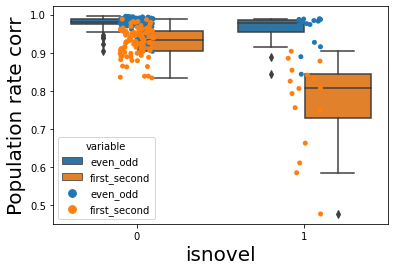

In [231]:
toplot=corr_pv.reset_index(level=2).rename({'level_2':'isnovel',},axis=1).melt(id_vars='isnovel')
fig,ax=plt.subplots()
sns.boxplot(data=toplot,x='isnovel',y='value',hue='variable',ax=ax) # per session
sns.stripplot(data=toplot,x='isnovel',y='value',hue='variable',ax=ax)
# ax.set(ylabel='PV Corr',title='Si > 0.5')
ax.set(ylabel='Population rate corr')


In [225]:
pv_corr_alltrials = gpb_sess.corr()
# pv_corr_alltrials = gpb_sess.apply(dist_one_df)
gpb_corr_sess=pv_corr_alltrials.groupby(level=(0,1,2,3))
pv_corr_per_lag=gpb_corr_sess.apply(get_val_per_lag)

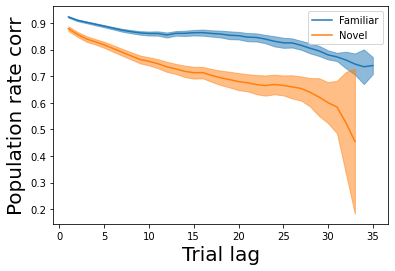

In [226]:
gpb_task=pv_corr_per_lag.groupby(level=(2))
fig,ax=plt.subplots()
isfam_d_str = {0:'Familiar',1:'Novel'}
for k,val in gpb_task:
    fig,ax=ph.mean_error_plot(val,fig=fig,ax=ax,label=isfam_d_str[k],c=f'C{k}')
    ax.set(xlabel='Trial lag',ylabel='Population rate corr')
ax.legend()

# when one field switch, how does it contribute to the drift

In [368]:
ani = 'e15_13f1'
sess = 'e15_13f1_220117'
per_field_metrics_all_sub = per_field_metrics_all.loc[ani,sess].query('si>0.5 & fit_var_ratio > 0.6')


/tmp/ipykernel_242409/3751403958.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  per_field_metrics_all_sub = per_field_metrics_all.loc[ani,sess].query('si>0.5 & fit_var_ratio > 0.6')


In [373]:
# ani,sess,ti,tt,uid,field_id=per_field_metrics_all_sub.index[0]
ti,tt,uid,field_id=per_field_metrics_all_sub.index[3]

In [374]:
frmap_oneuid=fr_map_trial_df_all.loc[ani,sess,ti,tt,uid].dropna(axis=1,how='all')

/tmp/ipykernel_242409/2885317756.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  frmap_oneuid=fr_map_trial_df_all.loc[ani,sess,ti,tt,uid].dropna(axis=1,how='all')


In [375]:
all_sw_with_metrics_d_all.loc[ani,sess,ti].query('trialtype==@tt&uid==@uid&field_index==@field_id')

/tmp/ipykernel_242409/3834299555.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_sw_with_metrics_d_all.loc[ani,sess,ti].query('trialtype==@tt&uid==@uid&field_index==@field_id')


,trialtype,uid,field_index,time,speed_gauss,field_pos,trial_index,switch,index_within,switch_trial,...,post_ntrial_le_10_perc_frac_total,post_ntrial_le_30_perc_frac_total,post_ntrial_le_50_perc_frac_total,post_ntrial_le_70_perc_frac_total,post_ntrial_le_90_perc_frac_total,post_ntrial_ge_10_perc_frac_total,post_ntrial_ge_30_perc_frac_total,post_ntrial_ge_50_perc_frac_total,post_ntrial_ge_70_perc_frac_total,post_ntrial_ge_90_perc_frac_total
188,0.0,73,0,8200.620167,4.742006,52.0,29,1.0,17,17.0,...,0.0,0.0,0.0,0.1,0.1,0.15,0.15,0.15,0.05,0.05


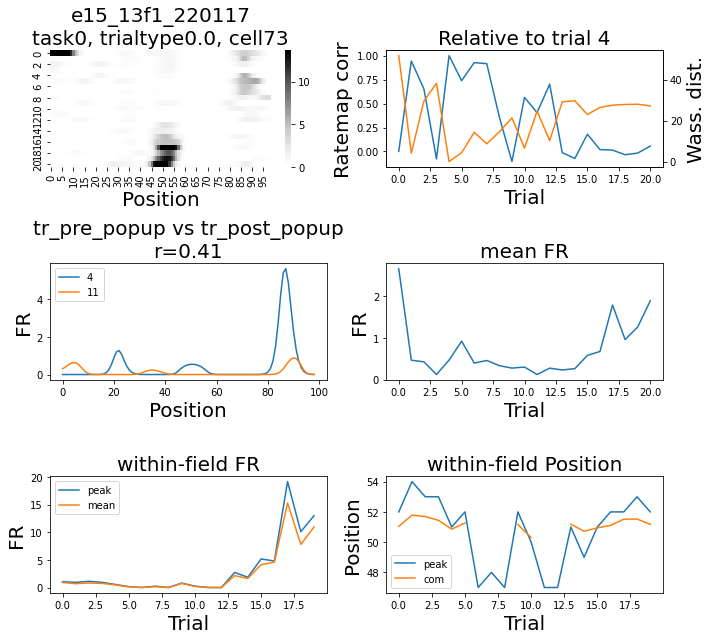

In [376]:
corrmat=frmap_oneuid.corr()
wass_d_l = get_wasserstein_dist_alltrials(frmap_oneuid)

fig,axs = plt.subplots(3,2,figsize=(10,9))
ax=axs[0,0]
fig,ax=ph.heatmap(frmap_oneuid.T,ax=ax)
ax.set_title(f'{sess}\ntask{ti}, trialtype{tt}, cell{uid}')

ax=axs[0,1]
tr=4

ax=corrmat.loc[tr].plot(ax=ax)
ax.set(title=f'Relative to trial {tr}',ylabel='Ratemap corr',xlabel='Trial')
ax2 = ax.twinx()
ax2.plot(wass_d_l.loc[tr],c='C1')
ax2.set(ylabel='Wass. dist.')

ax=axs[1,1]
frmap_oneuid.mean(axis=0).plot(ax=ax)
ax.set(title='mean FR', xlabel='Trial',ylabel='FR')


ax=axs[1,0]
tr_pre_popup=tr
tr_post_popup=11
frmap_oneuid.loc[:,tr_pre_popup].plot(ax=ax,legend='trial pre')
frmap_oneuid.loc[:,tr_post_popup].plot(ax=ax,legend='trial post')

ax.set(title=f'tr_pre_popup vs tr_post_popup\nr={corrmat.loc[tr_pre_popup,tr_post_popup]:.2f}',xlabel='Position',ylabel='FR')

ax=axs[2,0]
fr_peak_change=pf_params_recombined_all.loc[ani,sess,'fr_peak',ti,tt,uid,field_id].dropna()
fr_mean_change=pf_params_recombined_all.loc[ani,sess,'fr_mean',ti,tt,uid,field_id].dropna()
ax.plot(fr_peak_change.values,label='peak')
ax.plot(fr_mean_change.values,label='mean')
ax.legend()
ax.set(xlabel='Trial',ylabel='FR',title='within-field FR')

ax=axs[2,1]
field_peak_change=pf_params_recombined_all.loc[ani,sess,'peak',ti,tt,uid,field_id].loc[fr_peak_change.index]
field_com_change=pf_params_recombined_all.loc[ani,sess,'com',ti,tt,uid,field_id].loc[fr_peak_change.index]
ax.plot(field_peak_change.values,label='peak')
ax.plot(field_com_change.values,label='com')
ax.legend()
ax.set(xlabel='Trial',ylabel='Position',title='within-field Position')



plt.tight_layout()

In [320]:
def get_wasserstein_dist_alltrials(frmap_oneuid):

    cols=frmap_oneuid.columns
    ncols=len(cols)
    wass_d_l = np.zeros((ncols,ncols))
    for ii in range(ncols):
        tr_pre_popup = cols[ii]
        for jj in range(ii,ncols):
            tr_post_popup = cols[jj]
            wass_d=scipy.stats.wasserstein_distance(frmap_oneuid.index,frmap_oneuid.index,u_weights=frmap_oneuid.loc[:,tr_pre_popup],
                                         v_weights=frmap_oneuid.loc[:,tr_post_popup])
            wass_d_l[ii,jj] = wass_d
    wass_d_l = wass_d_l + wass_d_l.T
    wass_d_l = pd.DataFrame(wass_d_l,index=frmap_oneuid.columns,columns=frmap_oneuid.columns)
    return wass_d_l

# beg end FR difference per neuron

In [48]:
per_neuron_metrics_all = per_field_metrics_all.groupby(level=(0,1,2,3,4)).max()

In [49]:
# ma_ind=per_neuron_metrics_all.query('si>0.5&fit_var_ratio>0.4').index
ma_ind=per_neuron_metrics_all.query('si>0.5').index

# get rid of "both", replace with a copy with 0 and 1
ma_ind_new=[]
for ind in ma_ind:
    if ind[3]=='both':
        ma_ind_new.append((*ind[:3],0,*ind[4:]))
        ma_ind_new.append((*ind[:3],1,*ind[4:]))
    else:
        ma_ind_new.append(ind)
ma_ind_new = pd.MultiIndex.from_tuples(ma_ind_new)

In [50]:
from scipy.spatial.distance import pdist,squareform
from sklearn.metrics.pairwise import nan_euclidean_distances
def dist_one_df(x):
    x=x.dropna(axis=1,how='all')
#     mat=squareform(pdist(x.values.T,metric='sqeuclidean') / x.shape[0])
    mat = nan_euclidean_distances(x.values.T,x.values.T,squared=True) / x.shape[0]
    dist_df=pd.DataFrame(mat,index=x.columns,columns=x.columns)
    return dist_df

def get_plot_pf_param_population_corr_vs_lag(pf_params_all,ma_ind_new=None,pf_key='fr_peak',fig=None,ax=None,center_cell=None,zscore_cell=False,dist='corr'):
    
    df=pf_params_all.loc[(slice(None),slice(None),slice(None),slice(None),pf_key),:].droplevel(4)
    if center_cell is None:
        center_cell = False
        if pf_key=='peak' or pf_key=='com': # by default, no center; if location, then center
            center_cell=True
    if ma_ind_new is not None:
        pf_key_sub=df.reset_index(level=-1).loc[ma_ind_new].set_index('level_5',append='True')
    else:
        pf_key_sub = df
    if center_cell:
        pf_key_sub = pf_key_sub - pf_key_sub.mean(axis=1).values[:,None]
    if zscore_cell:
        pf_key_sub = scipy.stats.zscore(pf_key_sub,axis=1,nan_policy='omit')
#     pdb.set_trace()
    if dist =='corr':
        pf_key_corr_allsess = pf_key_sub.groupby(level=(0,1,2)).corr()
    elif dist=='mse':
        
        pf_key_corr_allsess = pf_key_sub.groupby(level=(0,1,2)).apply(dist_one_df)
#     pdb.set_trace()
    gpb_corr_sess=pf_key_corr_allsess.groupby(level=(0,1,2))
    pv_corr_per_lag=gpb_corr_sess.apply(get_val_per_lag)
    gpb_task=pv_corr_per_lag.groupby(level=(2))
    if ax is None:
        fig,ax=plt.subplots()
    isfam_d_str = {0:'Familiar',1:'Novel'}
    for k,val in gpb_task:
        fig,ax=ph.mean_error_plot(val,fig=fig,ax=ax,label=isfam_d_str[k],c=f'C{k}')
        ax.set(xlabel='Trial lag',ylabel=f'Place field {pf_key} {dist}')
    ax.legend()
    return fig,ax, pf_key_corr_allsess

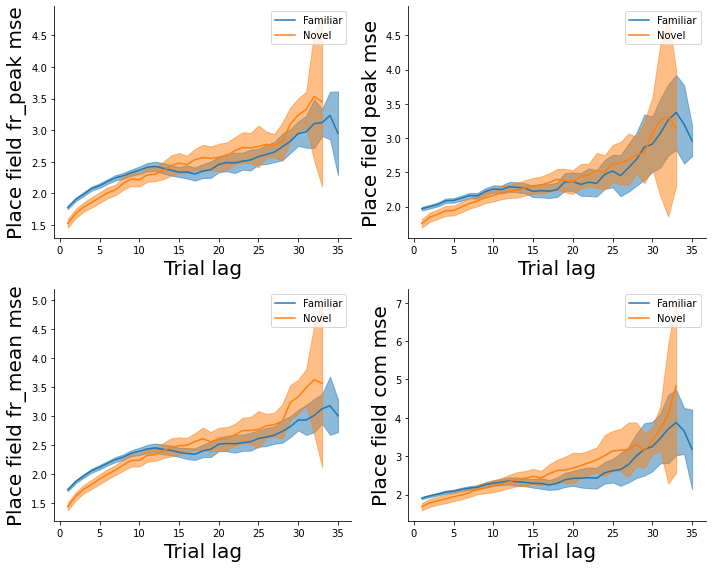

In [262]:
# pf_key = 'fr_peak'
fig,axs=plt.subplots(2,2,figsize=(10,8))
sns.despine()
dist = 'mse'
for ii,pf_key in enumerate(['fr_peak','peak','fr_mean','com']):
    ax=axs.ravel()[ii]
    fig,ax,pf_key_corr_allsess = get_plot_pf_param_population_corr_vs_lag(pf_params_all,ma_ind_new=None,pf_key=pf_key,fig=fig,ax=ax,center_cell=False,zscore_cell=True,dist=dist)
#     fig,ax,pf_key_corr_allsess = get_plot_pf_param_population_corr_vs_lag(pf_params_all,ma_ind_new=None,pf_key=pf_key,fig=fig,ax=ax,center_cell=False,zscore_cell=False,dist='mse')
#     ax.set_ylim([-0.2,1.1])
plt.tight_layout()
for fmt in ['png','svg']:
    fig_fn = f'{dist}_vs_triallag.{fmt}'
    fig.savefig(os.path.join(figdir,fig_fn),bbox_inches='tight')
    

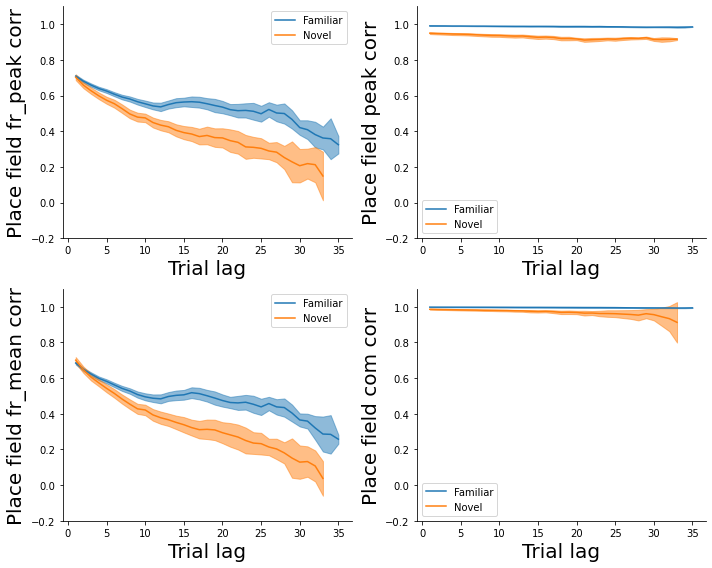

In [265]:
# pf_key = 'fr_peak'
fig,axs=plt.subplots(2,2,figsize=(10,8))
sns.despine()
dist = 'corr'
for ii,pf_key in enumerate(['fr_peak','peak','fr_mean','com']):
    ax=axs.ravel()[ii]
    fig,ax,pf_key_corr_allsess = get_plot_pf_param_population_corr_vs_lag(pf_params_all,ma_ind_new=None,pf_key=pf_key,fig=fig,ax=ax,center_cell=False,zscore_cell=False,dist=dist)
    ax.set_ylim([-0.2,1.1])
plt.tight_layout()
for fmt in ['png','svg']:
    fig_fn = f'{dist}_vs_triallag.{fmt}'
    fig.savefig(os.path.join(figdir,fig_fn),bbox_inches='tight')
    

# schematic for different ways things can drift

In [355]:
def gen_sim_plot(loc1 = 20,
    loc2 = 40,
    width=5,
    jitter = 0.,
    modulation = 1.,fig=None,ax=None,fs=15):
    xs=np.arange(100)
    r1=scipy.stats.norm(loc=loc1,scale=width).pdf(xs)
    r2=scipy.stats.norm(loc=loc2,scale=width).pdf(xs)
    r = np.concatenate([r1,r2])
    r3 = scipy.stats.norm(loc=loc1+jitter,scale=width).pdf(xs) * modulation
    r4 = scipy.stats.norm(loc=loc2+jitter,scale=width).pdf(xs) 
    r_next = np.concatenate([r3,r4])
    corr=np.corrcoef(r,r_next)
    
    if ax is None:
        fig,ax=plt.subplots()
    ax.plot(r,label='current trial',c='k')
    ax.plot(r_next,label='next trial',c='r')
    ax.set_title(f'r={corr[0,1]:.2f}')
    ax.set_xticks([len(xs)])
    ax.set_xticklabels([])
    ax.set_xlabel('Position (concatenated)')
#     ax.set_xticks([loc1,loc2 + len(xs)])
#     ax.set_xticklabels(['Neuron 1','Neuron 2'])
    ax.text(loc1,0.09,'Neuron 1',horizontalalignment='center',fontsize=fs)
    ax.text(loc2+len(xs),0.09,'Neuron 2',horizontalalignment='center',fontsize=fs)
    ax.set_ylim([0,0.1])
    ax.legend(bbox_to_anchor=[1.2,0.9],fontsize=fs)
    ax.set_yticks([])
    
    sns.despine(left=True)
    
    return fig,ax
    
    

In [370]:
def save_given_name(fig,figfn,figdir=figdir):
    for fmt in ['png','svg']:
        figfn_full = f'{figfn}.{fmt}'
        fig.savefig(os.path.join(figdir,figfn_full),bbox_inches='tight')
        

In [368]:
sns.set_context('poster')

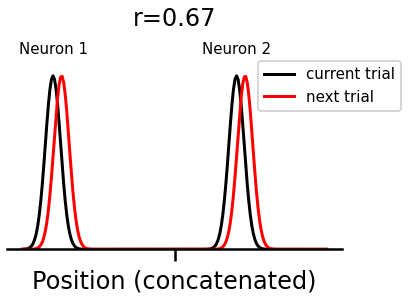

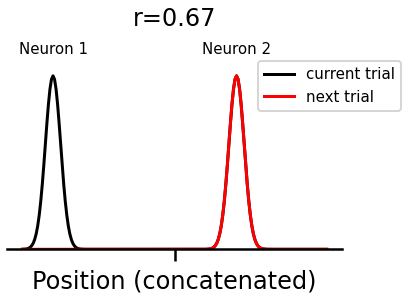

In [371]:
fig,ax=gen_sim_plot(jitter=5.6,modulation=1)
figfn = 'schematic_pos_induced_decorrelation'
save_given_name(fig,figfn)

fig,ax=gen_sim_plot(jitter=0,modulation=0.)
figfn = 'schematic_rate_induced_decorrelation'
save_given_name(fig,figfn)


In [51]:
pf_key = 'peak'#'fr_peak'
# pf_key_sub =pf_params_recombined_all.loc[(slice(None),slice(None),pf_key)].loc[ma_ind]
df=pf_params_all.loc[(slice(None),slice(None),slice(None),slice(None),pf_key),:].droplevel(4)
pf_key_sub=df.reset_index(level=-1).loc[ma_ind_new].set_index('level_5',append='True')


In [55]:
pf_key_sub

0     1     2     3     4   \
                                   level_5                                 
e13_16f1 e13_16f1_210302 0 0.0 12  0        28.0  22.0  16.0  15.0  15.0   
                                   1        48.0  58.0  54.0  53.0  53.0   
                               35  0        68.0  59.0  67.0  62.0  60.0   
                               37  0         0.0   0.0   0.0   0.0   0.0   
                                   1        98.0  98.0  98.0  98.0  98.0   
...                                          ...   ...   ...   ...   ...   
e16_3m2  e16_3m2_211213  1 0.0 157 0        17.0  19.0  17.0  19.0  19.0   
                           1.0 157 0        19.0  18.0  17.0  17.0  16.0   
                                   1        44.0  40.0  39.0  39.0  37.0   
                           0.0 190 0        14.0   8.0   6.0  14.0  11.0   
                           1.0 190 0        13.0  12.0   7.0   8.0  15.0   

                                              5     6     7     8     9   ...  \
                                   level_5                                ...   
e13_16f1 e13_16f1_210302 0 0.0 12  0        15.0  18.0  19.0  13.0  11.0  ...   
                                   1        53.0  52.0  52.0  53.0  52.0  ...   
                               35  0        62.0  67.0  65.0  63.0  68.0  ...   
                               37  0         0.0   0.0   0.0   0.0   0.0  ...   
                                   1        98.0  98.0  98.0  98.0  98.0  ...   
...                                          ...   ...   ...   ...   ...  ...   
e16_3m2  e16_3m2_211213  1 0.0 157 0        17.0  18.0  15.0  18.0  18.0  ...   
                           1.0 157 0        18.0  17.0  17.0  15.0  15.0  ...   
                                   1        42.0  41.0  41.0  42.0  43.0  ...   
                           0.0 190 0        12.0   9.0  10.0   6.0  13.0  ...   
                           1.0 190 0         8.0  13.0  13.0  13.0  12.0  ...   

                                            27  28  29  30  31  32  33  34  \
                                   level_5                                   
e13_16f1 e13_16f1_210302 0 0.0 12  0       NaN NaN NaN NaN NaN NaN NaN NaN   
                                   1       NaN NaN NaN NaN NaN NaN NaN NaN   
                               35  0       NaN NaN NaN NaN NaN NaN NaN NaN   
                               37  0       NaN NaN NaN NaN NaN NaN NaN NaN   
                                   1       NaN NaN NaN NaN NaN NaN NaN NaN   
...                                         ..  ..  ..  ..  ..  ..  ..  ..   
e16_3m2  e16_3m2_211213  1 0.0 157 0       NaN NaN NaN NaN NaN NaN NaN NaN   
                           1.0 157 0       NaN NaN NaN NaN NaN NaN NaN NaN   
                                   1       NaN NaN NaN NaN NaN NaN NaN NaN   
                           0.0 190 0       NaN NaN NaN NaN NaN NaN NaN NaN   
                           1.0 190 0       NaN NaN NaN NaN NaN NaN NaN NaN   

                                            35  36  
                                   level_5          
e13_16f1 e13_16f1_210302 0 0.0 12  0       NaN NaN  
                                   1       NaN NaN  
                               35  0       NaN NaN  
                               37  0       NaN NaN  
                                   1       NaN NaN  
...                                         ..  ..  
e16_3m2  e16_3m2_211213  1 0.0 157 0       NaN NaN  
                           1.0 157 0       NaN NaN  
                                   1       NaN NaN  
                           0.0 190 0       NaN NaN  
                           1.0 190 0       NaN NaN  

[10636 rows x 37 columns]

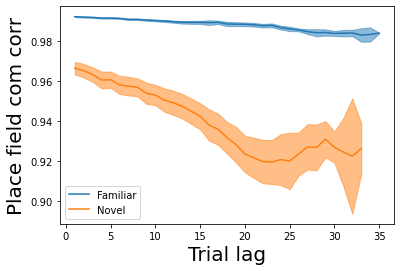

In [218]:
pf_key_corr_allsess = (pf_key_sub).groupby(level=(0,1,2)).corr()
# pf_key_corr_allsess = (pf_key_sub).groupby(level=(0,1,2)).apply(dist_one_df)

gpb_corr_sess=pf_key_corr_allsess.groupby(level=(0,1,2))
pv_corr_per_lag=gpb_corr_sess.apply(get_val_per_lag)
gpb_task=pv_corr_per_lag.groupby(level=(2))
fig,ax=plt.subplots()
isfam_d_str = {0:'Familiar',1:'Novel'}
for k,val in gpb_task:
    fig,ax=ph.mean_error_plot(val,fig=fig,ax=ax,label=isfam_d_str[k],c=f'C{k}')
    ax.set(xlabel='Trial lag',ylabel=f'Place field {pf_key} corr')
ax.legend()

In [414]:
pf_key_corr_allsess

0         1         2         3   \
e13_16f1 e13_16f1_210302 0 0   1.000000  0.615713  1.000000 -1.000000   
                           1   0.615713  1.000000  1.000000 -1.000000   
                           2   1.000000  1.000000  1.000000  0.675616   
                           3  -1.000000 -1.000000  0.675616  1.000000   
                           4   0.039775  0.480255 -1.000000  1.000000   
...                                 ...       ...       ...       ...   
e16_3m2  e16_3m2_211213  1 65       NaN       NaN       NaN       NaN   
                           66       NaN       NaN       NaN       NaN   
                           67       NaN       NaN       NaN       NaN   
                           68       NaN       NaN       NaN       NaN   
                           69       NaN       NaN       NaN       NaN   

                                     4         5         6         7   \
e13_16f1 e13_16f1_210302 0 0   0.039775  1.000000  0.199982  0.232062   
                           1   0.480255  1.000000  0.739279  0.802059   
                           2  -1.000000  0.657335  1.000000  1.000000   
                           3   1.000000  0.680363 -1.000000 -1.000000   
                           4   1.000000 -1.000000  0.773413  0.639934   
...                                 ...       ...       ...       ...   
e16_3m2  e16_3m2_211213  1 65       NaN       NaN       NaN       NaN   
                           66       NaN       NaN       NaN       NaN   
                           67       NaN       NaN       NaN       NaN   
                           68       NaN       NaN       NaN       NaN   
                           69       NaN       NaN       NaN       NaN   

                                     8         9   ...  60  61  62  63  64  \
e13_16f1 e13_16f1_210302 0 0   0.279630  1.000000  ... NaN NaN NaN NaN NaN   
                           1   0.742341  1.000000  ... NaN NaN NaN NaN NaN   
                           2   1.000000  0.405865  ... NaN NaN NaN NaN NaN   
                           3  -1.000000  0.351073  ... NaN NaN NaN NaN NaN   
                           4   0.750433 -1.000000  ... NaN NaN NaN NaN NaN   
...                                 ...       ...  ...  ..  ..  ..  ..  ..   
e16_3m2  e16_3m2_211213  1 65       NaN       NaN  ... NaN NaN NaN NaN NaN   
                           66       NaN       NaN  ... NaN NaN NaN NaN NaN   
                           67       NaN       NaN  ... NaN NaN NaN NaN NaN   
                           68       NaN       NaN  ... NaN NaN NaN NaN NaN   
                           69       NaN       NaN  ... NaN NaN NaN NaN NaN   

                               65  66  67  68  69  
e13_16f1 e13_16f1_210302 0 0  NaN NaN NaN NaN NaN  
                           1  NaN NaN NaN NaN NaN  
                           2  NaN NaN NaN NaN NaN  
                           3  NaN NaN NaN NaN NaN  
                           4  NaN NaN NaN NaN NaN  
...                            ..  ..  ..  ..  ..  
e16_3m2  e16_3m2_211213  1 65 NaN NaN NaN NaN NaN  
                           66 NaN NaN NaN NaN NaN  
                           67 NaN NaN NaN NaN NaN  
                           68 NaN NaN NaN NaN NaN  
                           69 NaN NaN NaN NaN NaN  

[3780 rows x 70 columns]

<Axes: >

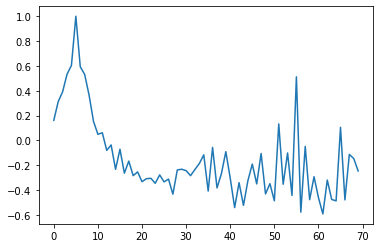

In [411]:
pf_key_corr.loc[5].plot()

In [322]:
wass_d_l

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.000000,20.197759,23.821890,22.982630,19.279621,22.318145,20.247887,21.668078,23.454547,21.902637,...,22.267123,19.008375,19.471179,17.481743,19.152023,17.601058,19.821733,16.931657,19.739896,23.555463
1,20.197759,0.000000,8.720723,8.214246,7.124096,8.564200,7.140474,8.033997,8.313424,5.561409,...,6.005996,5.980166,4.805945,5.107295,6.793874,11.371946,5.757210,10.855212,9.580180,19.999553
2,23.821890,8.720723,0.000000,0.943375,4.754337,1.594851,6.071520,2.859893,0.795764,4.288579,...,9.226379,9.062449,8.920269,6.742732,10.689900,15.966743,5.851482,14.738314,15.080801,25.767415
3,22.982630,8.214246,0.943375,0.000000,3.814171,1.657822,5.758454,2.546826,0.962685,4.369130,...,9.259266,8.749383,8.605414,5.899489,10.376833,15.653676,5.538415,14.425247,14.748346,25.454348
4,19.279621,7.124096,4.754337,3.814171,0.000000,3.651073,3.709070,2.655706,4.310244,5.600643,...,9.883338,7.143413,6.921637,3.681367,8.471025,13.591707,5.110917,12.363278,12.644484,23.392379
5,22.318145,8.564200,1.594851,1.657822,3.651073,0.000000,5.153135,1.825679,2.262066,4.801616,...,9.449075,8.187731,7.959320,5.947884,9.543043,14.819858,4.802412,13.591592,13.928017,24.623313
6,20.247887,7.140474,6.071520,5.758454,3.709070,5.153135,0.000000,3.354808,6.222464,4.076056,...,8.073343,5.061462,5.457070,4.622718,5.651841,9.895239,3.842530,8.836251,9.210266,19.695894
7,21.668078,8.033997,2.859893,2.546826,2.655706,1.825679,3.354808,0.000000,3.010837,4.453599,...,8.997071,6.614826,6.249466,4.925829,7.832336,13.106850,4.079248,11.878421,12.255345,22.907522
8,23.454547,8.313424,0.795764,0.962685,4.310244,2.262066,6.222464,3.010837,0.000000,4.415883,...,9.362599,9.213393,9.069396,6.369944,10.840844,16.117687,6.002426,14.889258,15.170464,25.918359
9,21.902637,5.561409,4.288579,4.369130,5.600643,4.801616,4.076056,4.453599,4.415883,0.000000,...,4.994132,4.797510,5.135101,4.499232,6.445293,11.701804,2.106262,10.563357,10.992813,21.502476


<Axes: >

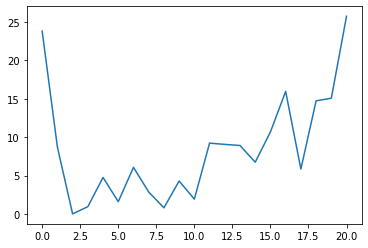

In [314]:
tr_pre_popup = 2
wass_d_l = {}
for tr_post_popup in frmap_oneuid.columns:
    wass_d=scipy.stats.wasserstein_distance(frmap_oneuid.index,frmap_oneuid.index,u_weights=frmap_oneuid.loc[:,tr_pre_popup],
                                 v_weights=frmap_oneuid.loc[:,tr_post_popup])
    wass_d_l[tr_post_popup] = wass_d
wass_d_l = pd.Series(wass_d_l)
wass_d_l.plot()

In [299]:

scipy.stats.pearsonr(frmap_oneuid.loc[:,2],frmap_oneuid.loc[:,9])

PearsonRResult(statistic=0.9254364574035843, pvalue=1.14171725051465e-42)

Text(0.5, 1.0, 'place field width')

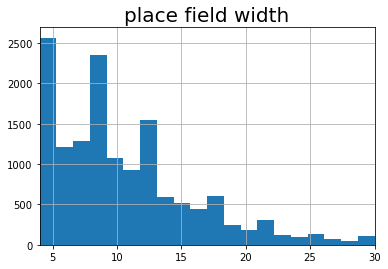

In [130]:
width=all_fields_recombined_all['end']-all_fields_recombined_all['start']
width = width.astype(float).dropna()
ax=(width).hist(bins=20)
plt.xlim([4,30])
ax.set_title('place field width')

1.6860843830553431 0.5449264473094236 2.384510797172963


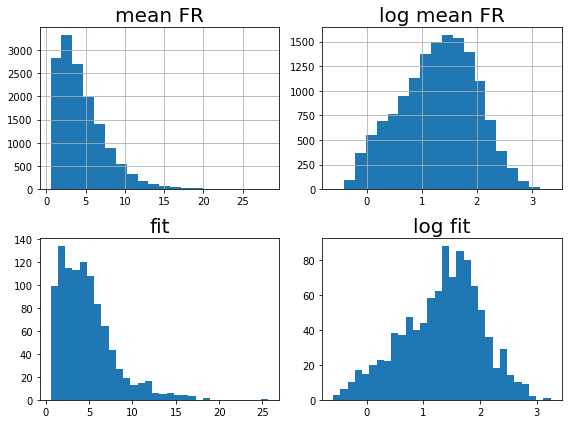

In [142]:
fig,axs=plt.subplots(2,2,figsize=(8,6))
eps=1e-10
fr=all_fields_recombined_all['fr_mean'].astype('float').dropna()
ax=axs[0,0]
ax=fr.hist(bins=20,ax=ax)
ax.set_title('mean FR')
ax=axs[0,1]
np.log(all_fields_recombined_all['fr_mean'].astype('float').dropna()+eps).hist(bins=20,ax=ax)
ax.set_title('log mean FR')


fit_a,fit_loc,fit_b=scipy.stats.gamma.fit(fr)
print(fit_a,fit_loc,fit_b)
fit_sample=scipy.stats.gamma.rvs(fit_a,loc=fit_loc,scale=fit_b,size=1000)
ax=axs[1,0]
_=ax.hist(fit_sample,bins=30)
ax.set_title('fit')
ax=axs[1,1]
_=ax.hist(np.log(fit_sample+eps),bins=30)
ax.set_title('log fit')
# plt.xlim([4,30])
plt.tight_layout()

Text(0.5, 1.0, 'log')

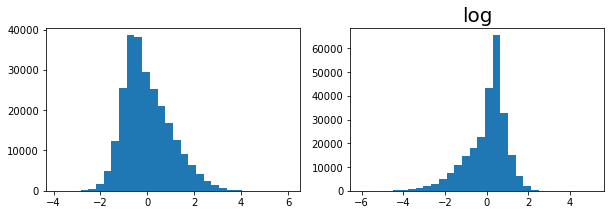

In [157]:
fr_mean_all=pf_params_all.loc[(slice(None),slice(None),slice(None),slice(None),'fr_mean'),:]
fr_mean_zscore=scipy.stats.zscore(fr_mean_all,axis=1,nan_policy='omit')
eps=1e-10
log_fr_mean_zscore=scipy.stats.zscore(np.log(fr_mean_all+eps),axis=1,nan_policy='omit')
fig,axs=plt.subplots(1,2,figsize=(10,3))
ax=axs[0]
ax.hist(fr_mean_zscore.values.flatten(),bins=30)
ax=axs[1]
ax.hist(log_fr_mean_zscore.values.flatten(),bins=30)
ax.set_title('log')



log cv mean 0.5202096672936729 log cv std 0.5584699805053144


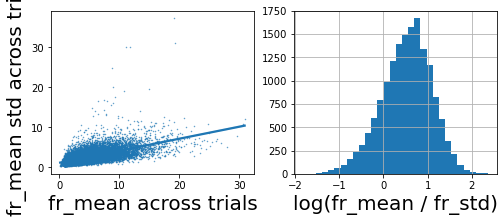

In [205]:
fr_mean_std_all=fr_mean_all.std(axis=1)
fr_mean_mean_all=fr_mean_all.mean(axis=1)
fr_mean_cv_all = fr_mean_mean_all /  fr_mean_std_all
fig,axs=plt.subplots(1,2,figsize=(8,3))
ax=axs[0]
ax=sns.regplot(fr_mean_mean_all,fr_mean_std_all,scatter_kws={'s':0.2},ax=ax)
ax.set(xlabel='fr_mean across trials',ylabel='fr_mean std across trials')
ax=axs[1]
log_fr_mean_cv_all=np.log(fr_mean_cv_all)
log_fr_mean_cv_all.hist(ax=ax,bins=30)
ax.set(xlabel='log(fr_mean / fr_std)')
print('log cv mean', log_fr_mean_cv_all.mean(),'log cv std', log_fr_mean_cv_all.std())


(array([4.153e+03, 6.673e+03, 3.295e+03, 1.107e+03, 3.480e+02, 1.060e+02,
        2.200e+01, 5.000e+00, 7.000e+00, 3.000e+00]),
 array([ 0.16441084,  1.21395547,  2.2635001 ,  3.31304472,  4.36258935,
         5.41213398,  6.46167861,  7.51122323,  8.56076786,  9.61031249,
        10.65985712]),
 <BarContainer object of 10 artists>)

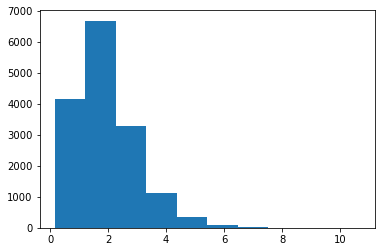

In [203]:
plt.hist(fr_mean_cv_all)

0.8484271227647034 3.9999999999999996 6.5788776343264495


(4.0, 30.0)

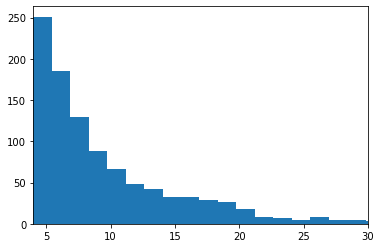

In [94]:
fit_a,fit_loc,fit_b=scipy.stats.gamma.fit(width)
print(fit_a,fit_loc,fit_b)
fit_sample=scipy.stats.gamma.rvs(fit_a,loc=fit_loc,scale=fit_b,size=1000)
plt.hist(fit_sample,bins=30)
plt.xlim([4,30])